In [1]:
import os
import argparse
import glob
import numpy as np
import pickle
import json
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from projection_utils import Projection
from data_parser import read_keypoints

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sys
sys.path.append('../virtual_huams_resource')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


c:\Users\benja\Anaconda3\envs\torch3d\lib\site-packages\tqdm-4.64.0-py3.9.egg\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_root = 'D:/prox_data/recordings_small'
sequence_id = 'MPH8_00034_01'
save_root = '../temp_data/'

fp = data_root + '/' + sequence_id

In [3]:
from benji_prox_dataloader import proxDatasetSkeleton, proxDatasetProximityMap

In [4]:
dd = proxDatasetProximityMap(fittings_dir='D:/prox_data/PROXD_fittings_small', depth_dir='D:/prox_data/recordings_small', calibration_dir='D:/prox_data/calibration')

In [5]:
fn1, fn2, depth_img, skel_dict = dd.__getitem__(0)
fn1
fn2

'D:\\prox_data\\recordings_small\\MPH8_00168_01\\Depth\\s001_frame_00001__00.00.00.029.png'

'D:\\prox_data\\PROXD_fittings_small\\MPH8_00168_01\\results\\s001_frame_00001__00.00.00.029\\000.pkl'

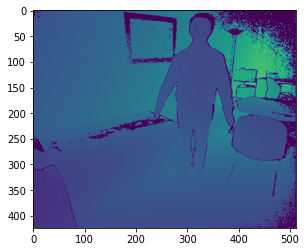

In [6]:
plt.imshow(depth_img)

In [8]:
from utils import *

In [9]:
depth_map = depth_img
skeleton_dict = skel_dict
smplx_model_path='../models_smplx_v1_1/models/'
body_model = get_smplx_body_model(smplx_model_path)
depth_cam = dd.proj.depth_cam
alignment_cam = dd.proj.color_cam

pcd, pcd_color_aligned, skeleton, body_bps_full= \
     proximity_map(depth_map, skeleton_dict, body_model, depth_cam, alignment_cam)

In [11]:
o3d.visualization.draw_geometries([skeleton, pcd_color_aligned])

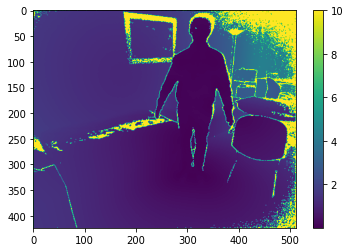

In [15]:
h, w = depth_img.shape
body_bps_full = body_bps_full.reshape((h, w))  # body bps feature map, [h, w]
body_bps_full = body_bps_full.astype(np.float32)
plt.imshow(body_bps_full)
plt.colorbar()

In [16]:
len(dd)

3071

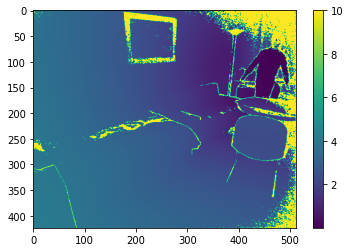

In [17]:
fn1, fn2, depth_img, skel_dict = dd.__getitem__(3000)

depth_map = depth_img
skeleton_dict = skel_dict
smplx_model_path='../models_smplx_v1_1/models/'
body_model = get_smplx_body_model(smplx_model_path)
depth_cam = dd.proj.depth_cam
alignment_cam = dd.proj.color_cam

pcd, pcd_color_aligned, skeleton, body_bps_full= \
     proximity_map(depth_map, skeleton_dict, body_model, depth_cam, alignment_cam)

h, w = depth_map.shape
body_bps_full = body_bps_full.reshape((h, w))  # body bps feature map, [h, w]
body_bps_full = body_bps_full.astype(np.float32)
plt.imshow(body_bps_full)
plt.colorbar()

In [24]:
joint_locations, body_points =  get_joint_locations(skeleton_dict, body_model)

skeleton = o3d.geometry.PointCloud()
skeleton.points = o3d.utility.Vector3dVector(body_points)

depth_cam = copy.deepcopy(depth_cam)
scale_camera_dict(depth_cam)

pcd = o3d.geometry.PointCloud()
proj = dd.proj
proj_points = proj.unproject_depth_image(depth_map, proj.depth_cam).reshape(-1, 3)
norms = np.linalg.norm(proj_points, axis=1)
eps = 1.0
proj_points = proj_points[norms > eps]
pcd.points = o3d.utility.Vector3dVector(proj_points)

points = np.asarray(pcd.points)
points[:, 2] /= DEPTH_SCALE
points[:, 0] /= DEPTH_SCALE
points[:, 1] /= DEPTH_SCALE
pcd.points = o3d.utility.Vector3dVector(points)

points_color_aligned = align_point_clouds(points, depth_cam, alignment_cam)
pcd_color_aligned = o3d.geometry.PointCloud()
pcd_color_aligned.points = o3d.utility.Vector3dVector(points_color_aligned)


In [ ]:
o3d.visualization.draw_geometries([skeleton, pcd])

(array([[1.95574e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
        [1.95574e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
        [0.00000e+00, 9.09900e+03, 8.84500e+04, 5.47230e+04, 2.87660e+04,
         1.00950e+04, 4.39900e+03, 3.60000e+01, 3.00000e+00, 3.00000e+00]]),
 array([-1.71188383e-06,  7.83798454e-01,  1.56759862e+00,  2.35139878e+00,
         3.13519895e+00,  3.91899912e+00,  4.70279928e+00,  5.48659945e+00,
         6.27039961e+00,  7.05419978e+00,  7.83799994e+00]),
 <a list of 3 BarContainer objects>)

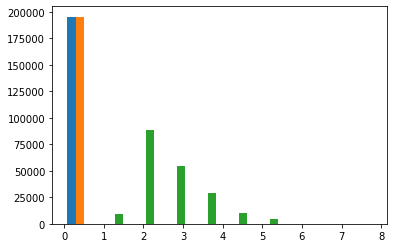

In [23]:
plt.hist(points)

In [11]:
pcd_color_aligned

PointCloud with 195793 points.

In [12]:
import os
os.getcwd()
os.listdir('../models_smplx_v1_1/models/')

'c:\\Users\\benja\\coding\\eth\\prox\\src'

['SMPLX_FEMALE.npz',
 'SMPLX_FEMALE.pkl',
 'SMPLX_MALE.npz',
 'SMPLX_MALE.pkl',
 'SMPLX_NEUTRAL.npz',
 'SMPLX_NEUTRAL.pkl',
 'smplx_npz.zip',
 'version.txt']